# Actualization Criteria

In this tutorial we will explore a few ideas, starting from the notion of restricted Max-Ent dynamics and naturally developing the ideas and methods behind adaptive Max-Ent, designed to address shortcomings of the former. 

Guide of contents: 

0. Getting started: basics 
1. Understanding the restricted Max-Ent scheme
   a. Elements, examples & Challenges
2. Adaptive Max-Ent scheme 
   1. Partial Sum criterion
   2. Lieb-Robinson criterion

## 0. Getting started basics

### 0.a Importing libraries
First, we import the relevant packages.

In [1]:
import sys 
path= 'C:/Users/Tomas/PhD_Physics/3rd_Year/github_repo/'
sys.path.insert(1, path) 

### long term ev 
import matplotlib.pyplot as plt
import numpy as np

# Configuration du style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'font.size': 12,        # Taille de police
    'axes.labelsize': 14,   # Taille des labels des axes
    'axes.titlesize': 16,   # Taille des titres
    'legend.fontsize': 12,  # Taille des légendes
    'xtick.labelsize': 12,  # Taille des labels des ticks sur l'axe X
    'ytick.labelsize': 12,  # Taille des labels des ticks sur l'axe Y
    'font.family': 'serif', # Police de type "serif" pour un rendu professionnel
    'axes.linewidth': 1.5,  # Largeur des bordures des axes
    'grid.alpha': 0.5       # Transparence des grilles
})

import numpy as np
import scipy.linalg as linalg

from IPython.display import display_latex
from alpsqutip.geometry import graph_from_alps_xml, list_graph_in_alps_xml
from alpsqutip.alpsmodels import list_operators_in_alps_xml,model_from_alps_xml
from alpsqutip.utils import eval_expr
from alpsqutip.model import SystemDescriptor

import qutip as qutip
from typing import Callable, Optional, Tuple

models_lib_file = "../alpsqutip/lib/models.xml"
lattice_lib_file = "../alpsqutip/lib/lattices.xml"

In [2]:
from alpsqutip import restricted_maxent_toolkit as me ## custom libary including basic linear algebra functions 
from alpsqutip.proj_evol import safe_exp_and_normalize ## function used to safely and robustly map K-states to states
from alpsqutip.operators.states.meanfield import one_body_from_qutip_operator, project_to_n_body_operator, self_consistent_quadratic_mfa
## functions used for Mean-Field projections

### 0.b Constructing the Hamiltonian 

Using the ALPS library, we construct a one-dimensional $L=7$ qubit **XYZ** spin chain with open boundary conditions as well as some operators of interest. 

We define the relevant parameters of the system for our one-dimensional **XYZ** Hamiltonian with open boundary conditions, that is, $J_x, J_y, J_z$ with no external magentic field. 

In particular, as it will become relevant later on, we calculate the Lieb-Robinson velocity $v_{\rm LR}$ which depends solely on the previously afforementioned parameters and is an intrinsic property of the system.  

The full derivation, drawn from the commutativity diagram of the system, can be found in Wang et al. (2020). 

In [3]:
params={}

params['size']=7
params['Jx']=1.; params['Jy'] = .75*params['Jx']; params['Jz']=1.05*params['Jx']

from scipy.optimize import root, fsolve
Ffactor=np.real(max(np.roots(np.poly1d([1, 0, -(params['Jx']*params['Jy']+params['Jx']*params['Jy']+params['Jy']*params['Jz']), 
                           -2*params['Jx']*params['Jy']*params['Jz']]))))
chi_y=fsolve(lambda x,y: x*np.arcsinh(x)-np.sqrt(x**2+1)-y, 1e-1, args=(0))[0]
vLR=4*Ffactor*chi_y

In [4]:
system=SystemDescriptor(
    model=model_from_alps_xml(models_lib_file, "spin"),
    graph=graph_from_alps_xml(lattice_lib_file, "open chain lattice", parms={"L":params['size'], "a":1}),
    parms={"h":0,"J":params['Jx']}
)

sites=[s for s in system.sites]
sx_ops=[system.site_operator("Sx", '1[' + str(a) + ']') for a in range(len(system.sites))]
sy_ops=[system.site_operator("Sy", '1[' + str(a) + ']') for a in range(len(system.sites))]
sz_ops=[system.site_operator("Sz", '1[' + str(a) + ']') for a in range(len(system.sites))]

H = (params['Jx']*sum(sx_ops[i]*sx_ops[i+1] for i in range(params['size']-1)) + params['Jy']*sum(sy_ops[i]*sy_ops[i+1] for i in range(params['size']-1))
     +params['Jz']*sum(sz_ops[i]*sz_ops[i+1] for i in range(params['size']-1)))
idop=system.site_operator("identity", sites[0])

### 0.c Defining the initial state

In general, and without any loss of generality, the initial state of the system $\rho(0)=\rho_0=e^{-{\bf K}}$ is known in such a way that the initial Max-Ent state coincides ${\bf K}_0 = \log \sigma_0 = \log \rho(0)$. We are interested in the following state, 

$$
    {\bf K}= \vec{\phi(0)_{i=1}} \cdot \vec{{\bf S}_{i=1}},
$$

leading to 

$$
    \rho_0=\sigma_0=|{\uparrow}\rangle \langle \uparrow|_{i=1} \otimes {\rm Id}_{i \neq 1}.
$$

In [5]:
HBB0=[idop, system.site_operator('Sx', '1[0]'), system.site_operator('Sy', '1[0]'), system.site_operator('Sz', '1[0]')]

phi0 = np.array([.0, .25, .25, -100.])
K0 = me.Kstate_from_phi_basis(phi0, HBB0)
sigma0 = safe_exp_and_normalize(K0)[0]
phi0[0] = np.log(sigma0.tr())
K0 = me.Kstate_from_phi_basis(phi0, HBB0)
sigma0 = safe_exp_and_normalize(K0)[0]
[(sigma0 * op).tr() for op in sz_ops] 

[0.4999968750292966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

Moreover, we define a few quantities of interest and the simulation timespan.

In [25]:
ptrace_list=[i for i in range(0,3)]
obs_SzA=.5*qutip.tensor(qutip.sigmaz(),qutip.qeye(2),qutip.qeye(2))+.5*qutip.tensor(qutip.qeye(2),qutip.sigmaz(),qutip.qeye(2))+.5*qutip.tensor(qutip.qeye(2),qutip.qeye(2),qutip.sigmaz())
obs_Sx3Sx4=(sx_ops[2]*sy_ops[3]).to_qutip()

timespan=np.linspace(.0, 650.1/vLR,800)

## 2. Understanding the Restricted Max-Ent Scheme  
### a. Elements, Examples, & Challenges  

The Restricted Max-Ent framework consists of the following key elements:  

* **Basis of Observables**:  
  In the case of time-independent Hamiltonians, the optimal choice for the basis is a **Hierarchical Basis**. This basis systematically expands the Krylov subspace, ensuring that the most relevant observables for the system's dynamics are included.  

* **Instantaneous Scalar Product**:  
  The scalar product plays a crucial role in defining the orthogonality and normalization conditions within the Restricted Max-Ent scheme. It determines how observables and state updates are related during the evolution process.  

In this demo, we present a simplified version of the Restricted Max-Ent scheme. Specifically:  
- The equation of motion is **linearized**, allowing for more computationally efficient updates.  
- The scalar product is **fixed to the initial state**, $\sigma_0$, rather than adapting dynamically. This simplification highlights the fundamental aspects of the approach while avoiding the complexities of fully updating the scalar product at each time step.  

### Challenges in the Restricted Max-Ent Scheme:  
1. **Dynamic Adaptation of the Basis**:  
   As the system evolves, the Krylov subspace may need frequent updates, especially when the Lieb-Robinson velocity bounds are exceeded, requiring computationally expensive actualizations.  

2. **Error Propagation**:  
   Linearizing the equation of motion can introduce truncation errors that accumulate over time. This necessitates careful monitoring of errors and potential re-orthogonalization steps.  

3. **Scalability**:  
   Extending this framework to larger systems or higher-dimensional Hilbert spaces remains challenging due to the exponential growth of the basis size.  

This demo aims to provide an intuitive understanding of the Restricted Max-Ent scheme's core components while demonstrating its application to time-evolving quantum systems.  


In [35]:
sp_local_non_act=me.fetch_covar_scalar_product(sigma=sigma0.to_qutip()) ## choosing of the scalar product
HBB_ell_non_act=me.build_Hierarch(generator=H, seed_op=K0.to_qutip(), deep=4) ## Hierarchical Basis of 

orth_basis_non_act=me.orthogonalize_basis(basis=HBB_ell_non_act, sp=sp_local_non_act)

Hij_tensor_non_act=me.fn_Hij_tensor(generator=H.to_qutip(),
                                 basis=orth_basis_non_act, 
                                 sp=sp_local_non_act) ## construction of the Max-Ent generator of transformations. 

phi0_proj_non_act=np.real(me.project_op(K0.to_qutip(), orth_basis_non_act, sp_local_non_act)) ## initial condition

phi_at_timet=[linalg.expm(Hij_tensor_non_act * (t-0))@phi0_proj_non_act for t in timespan] ## time-evolved coefficients

K_at_timet=[me.Kstate_from_phi_basis(phi=-phi_at_timet_ti, basis=orth_basis_non_act) for phi_at_timet_ti in phi_at_timet] ## Kstates

sigma_at_timet=[safe_exp_and_normalize(K_at_timet_ti)[0] for K_at_timet_ti in K_at_timet] ## sigma-states

ev_obs1 = np.array([qutip.expect(sigma_at_timet_ti.ptrace(ptrace_list), obs_SzA) for sigma_at_timet_ti in sigma_at_timet])

On the other hand, we compute the exact evolution with QuTip and compare

In [26]:
## exact dynamics
exact_K_at_timet=qutip.mesolve(H=H.to_qutip(), rho0=K0.to_qutip(), tlist=timespan)
exact_rho_at_timet=[safe_exp_and_normalize(K_at_timeti)[0] for K_at_timeti in exact_K_at_timet.states]
evs_obs_ex=[qutip.expect(rho_at_timeti.ptrace(ptrace_list), obs_SzA) for rho_at_timeti in exact_rho_at_timet]

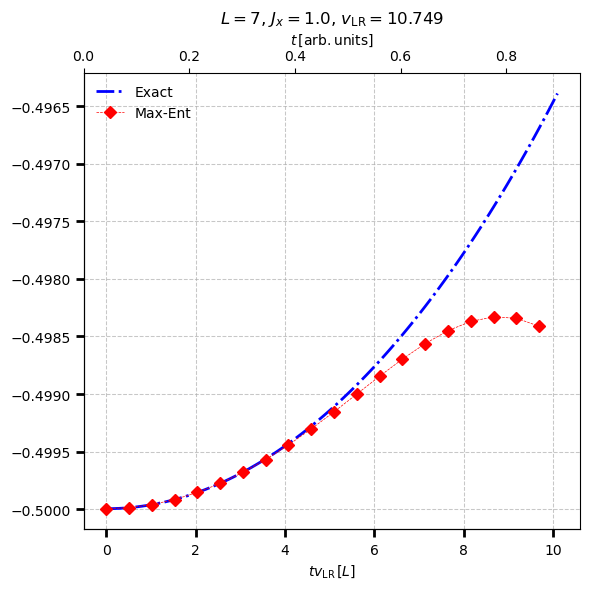

In [39]:
# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(6, 6))

n=5
ax.plot(timespan * vLR, evs_obs_ex, label='Exact', color="blue", linestyle='dashdot', linewidth=2)
ax.plot(timespan[::n] * vLR, ev_obs1[::n], label='Max-Ent', color='red', linestyle='--', marker='D', linewidth=0.5)

# Bordures uniquement à gauche et en bas (style minimaliste)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Personnalisation des ticks
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)

ax.legend(frameon=False, loc='upper left')

# Create a secondary x-axis (twinned) and set its limits
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[-1])

# Set axis labels
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Format the title using the `params` dictionary values
# Ensure proper LaTeX formatting and consistent escape sequences
plt.title(r'$L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

# Ajustement final et affichage
plt.tight_layout()

# 2. Adaptive Max-Ent Schemes  

Restricted Max-Ent dynamics provide an accurate representation of quantum evolution for short-term dynamics. However, as time progresses, the **polynomial buildup of error** becomes evident, limiting the validity of the restricted Max-Ent approac
. This limitation arises from the fact that a **fixed basis** can only capture the relevant correlations and observablefor so longme.  

Despite these limitations, it can be proven (using Lieb-Robinson bounds) that restricted Max-Ent dynamics are **exact for short-term evolution**. This motivates the idea of extending its applicability by introducing **aatdaptmethodsisms** to dynamically update the basis and scalar products. These updates allow the framework to correct deviations and force it to closely follow the exact dynamics over longer timescales
In the following cells, we provide the **code implementation** for these actualization criteria, illustrating how they dynamically update the restricted Max-Ent framework to achieve accurate and adaptable dynamics.  
.  

### Theat Adaptive Approach  
The central concept of adaptive Max-Ent schemes is to exploit the success of short-term restricted Max-Ent dynamics and systematically **update the basis and scalar products** using predefined criteria. By incorporating these updates, the method can extend its validity to longer times while maintaining accuracy.  

In particular, there are **two approaches** to determine the actualization times, which we detail below:  

### 2.1 Partial Sum Criterion  
This approach leverages the convergDysonf the Krylov expansion by monitoring the **partialof the basis coefficients**. The idea is to track the contribution of higher-order terms in the expansion:  
- If the contribution of higher-order terms exceeds a predefined threshold, the current basis is deemed insufficient, and the actualization is triggered.  
- During actualization, the basis is updated by including higher-order observables, and the scalar product is recalculated to reflect the updated state.  

This criterion is computationally efficient, as it directly ties the actualization to the system's dynamical properties, ensuring updates are performed only wdaptable dynamics.  


In [27]:
chosen_depth=4
# Initialize variables to track errors, saved cut times, expectation values, and commutators
local_bound_error = []; saved_cut_times_index = [0]; 
no_acts = [0]; number_of_commutators = [chosen_depth]

ev_obs_maxent_act_partialSum = [qutip.expect(sigma0.to_qutip().ptrace(ptrace_list), obs_SzA)]

# Compute the scalar product operator used for orthogonalization
sp_local = me.fetch_covar_scalar_product(sigma=sigma0.to_qutip()); local_t_value = .0  

# Build the initial Krylov basis and orthogonalize it
HBB_ell_act = me.build_Hierarch(generator=H, seed_op=K0.to_qutip(), deep=chosen_depth)  
orth_basis_act = me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)  

# Compute the Hamiltonian tensor for the basis
Hij_tensor_act = me.fn_Hij_tensor(generator=H.to_qutip(), basis=orth_basis_act, sp=sp_local)  

# Initial condition
phi0_proj_act = me.project_op(K0.to_qutip(), orth_basis_act, sp_local)  

# Initialize lists to store time-evolved values
phi_at_timet = [phi0_proj_act]  
K_at_timet = [K0.to_qutip()]  
sigma_at_timet = [me.safe_expm_and_normalize(K_at_timet[0])]  

# Iterate through the time steps
for t in timespan[1:]:
    # Evolve the state phi(t) for a small time window
    phi_local = np.real(linalg.expm(Hij_tensor_act * (t - local_t_value)) @ phi0_proj_act)  
    
    # Compute the new K-state from the orthogonal basis and phi(t)
    K_local = me.Kstate_from_phi_basis(phi=-phi_local, basis=orth_basis_act)  
    
    # Normalize to obtain the updated density matrix sigma(t)
    sigma_local = safe_exp_and_normalize(K_local)[0]  
    
    # Record expectation values of the observable
    ev_obs_maxent_act_partialSum.append(qutip.expect(sigma_local.ptrace(ptrace_list), obs_SzA))  
    
    # Calculate the local error bound using partial sums
    local_bound_error.append(me.m_th_partial_sum(phi=phi_local, m=2) / me.m_th_partial_sum(phi=phi_local, m=0))  
    
    # Check if the local error exceeds the threshold
    if abs(local_bound_error[-1]) >= 1e-2:
        # If positive, perform actualization
        no_acts.append(no_acts[-1] + 1)  
        number_of_commutators.append(number_of_commutators[-1] + 3)  

        # Log errors at specific intervals for debugging
        if list(timespan).index(t) % 50 == 0:  
            print("error", t)  
        
        # Update the local time value and save the cut time index
        local_t_value = t  
        saved_cut_times_index.append(list(timespan).index(t))  
        
        # Recompute the scalar product and update the Krylov basis
        sp_local = me.fetch_covar_scalar_product(sigma=sigma_local)  
        HBB_ell_act = me.build_Hierarch(generator=H, seed_op=K_local, deep=chosen_depth)  
        orth_basis_act = me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local)  
        
        # Recompute the Hamiltonian tensor and project the state
        Hij_tensor_act = me.fn_Hij_tensor(generator=H.to_qutip(), basis=orth_basis_act, sp=sp_local)  
        phi0_proj_act = me.project_op(K_local, orth_basis_act, sp_local)  
    else:
        # If error is below the threshold, retain the current basis and sp
        number_of_commutators.append(number_of_commutators[-1])  
        no_acts.append(no_acts[-1])  


error 3.7847090300247723
error 7.569418060049545
error 11.354127090074316
error 15.13883612009909
error 18.92354515012386
error 22.708254180148632
error 26.492963210173407
error 30.27767224019818
error 34.06238127022295
error 37.84709030024772
error 41.63179933027249
error 45.416508360297264
error 49.201217390322036
error 52.985926420346814
error 56.770635450371586


## 2.2.B Lieb-Robinson Criterion

The **Lieb-Robinson Criterion** provides a natural way to determine actualization times by leveraging the concept of the **Lieb-Robinson velocity** $v_{\rm LR}$. This velocity represents the (finite) speed at which information propagates through a quantum system, setting an effective "light cone" for correlations and observables.  

#### Key Idea:  

The basis and scalar products used in the Restricted Max-Ent framework should remain accurate within the bounds imposed by $v_{\rm LR}$. Once the system's evolution starts introducing correlations or observables outside this effective light cone, the existing basis becomes insufficient, and actualization is triggered.

#### Implementation:  

1. **Defining Actualization Times**:  
   - Divide the total simulation timespan into **slices** based on the Lieb-Robinson velocity, such that:  
     $$ t_{\rm cut} = m \frac{\ell}{v_{\rm LR}} $$  
     Here, $\ell$ represents the depth of the Hierarchical Basis, $m$ is an integer, and $t_{\rm cut}$ represents the cut times at which the updates occur.  

2. **Monitoring the Evolution**:  
   - The system's state and observables are evolved within each time slice.  
   - At the end of the slice, the basis is checked for relevance based on $v_{\rm LR}$. If necessary, the basis and scalar products are updated to ensure that the dynamics remain consistent with the exact evolution.  

3. **Advantages**:  
   - The Lieb-Robinson Criterion ensures that updates are **causality-preserving**, as new observables and correlations only appear within the physical bounds of information propagation.  
   - It avoids unnecessary updates by coupling the actualization strictly to the system's dynamical properties, ensuring efficiency.  

#### Application in the Adaptive Max-Ent Scheme:  

This criterion is particularly useful for systems with **localized interactions**, where $v_{\rm LR}$ provides a clear indication of how quickly correlations spread. By aligning the updates to $t_{\rm cut}$, the Adaptive Max-Ent scheme can accurately follow the exact dynamics while maintaining computational efficiency.
 computational efficiency.
for long-term evolution.  


In [31]:
# Define the range of time slices based on Lieb-Robinson velocity (vLR)
ells = [ell for ell in range(0, int(timespan[-1] * vLR) + 1, 1)]  
tcuts = [ell / vLR for ell in ells]  # Compute cut times from velocity
sliced_times = me.slice_times(timespan, tcuts)  # Slice the timespan into segments based on cut times

# Initialize the first Krylov state and compute the first expectation value
K_local_last = me.Kstate_from_phi_basis(phi=phi0, basis=HBB0).to_qutip()  
ev_obs_maxent_LR = [qutip.expect(safe_exp_and_normalize(K_local_last)[0].ptrace(ptrace_list), obs_SzA)]  

# Loop over all slices based on the Lieb-Robinson scheme
for ell in ells:
    print("Starting simulation: d=", ell)  
    
    # Fetch the scalar product operator for orthogonalization
    sp_local_act = me.fetch_covar_scalar_product(sigma=safe_exp_and_normalize(K_local_last)[0])  
    
    # Build and orthogonalize the Krylov basis for this segment
    HBB_ell_act = me.build_Hierarch(generator=H, seed_op=K0.to_qutip(), deep=chosen_depth+1)  
    orth_basis_act = me.orthogonalize_basis(basis=HBB_ell_act, sp=sp_local_act)  
    
    # Compute the Hamiltonian tensor and project the state onto the basis
    Hij_tensor_act = me.fn_Hij_tensor(generator=H.to_qutip(), basis=orth_basis_act, sp=sp_local_act)  
    phi0_proj_act = me.project_op(K_local_last, orth_basis_act, sp=sp_local_act)  
    
    # Time-evolve the state within the current slice
    phi_at_timet = [linalg.expm(Hij_tensor_act * (t - sliced_times[ell][0])) @ np.real(phi0_proj_act) 
                    for t in sliced_times[ell]]  
    
    # Convert evolved states into K-states and compute the density matrices
    K_at_timet = [me.Kstate_from_phi_basis(phi=-phi_at_timet_ti, basis=orth_basis_act) 
                  for phi_at_timet_ti in phi_at_timet]  
    sigma_at_timet_local = [safe_exp_and_normalize(K_at_timet_ti)[0].ptrace(ptrace_list) 
                            for K_at_timet_ti in K_at_timet]  
    
    # Compute expectation values for the observable over the segment
    ev_obs_maxent_LR += [qutip.expect(sigma_at_timet_local_ti, obs_SzA) 
                         for sigma_at_timet_local_ti in sigma_at_timet_local]  
    
    # Update the last K-state for the next segment and clean up temporary variables
    K_local_last = K_at_timet[-1]  
    phi_at_timet = None  
    K_at_timet = None  
    
    print("Finishing simulation.")  # End of the segment simulation


Starting simulation: d= 0
Finishing simulation.
Starting simulation: d= 1
Finishing simulation.
Starting simulation: d= 2
Finishing simulation.
Starting simulation: d= 3
Finishing simulation.
Starting simulation: d= 4
Finishing simulation.
Starting simulation: d= 5
Finishing simulation.
Starting simulation: d= 6
Finishing simulation.
Starting simulation: d= 7
Finishing simulation.
Starting simulation: d= 8
Finishing simulation.
Starting simulation: d= 9
Finishing simulation.
Starting simulation: d= 10
Finishing simulation.
Starting simulation: d= 11
Finishing simulation.
Starting simulation: d= 12
Finishing simulation.
Starting simulation: d= 13
Finishing simulation.
Starting simulation: d= 14
Finishing simulation.
Starting simulation: d= 15
Finishing simulation.
Starting simulation: d= 16
Finishing simulation.
Starting simulation: d= 17
Finishing simulation.
Starting simulation: d= 18
Finishing simulation.
Starting simulation: d= 19
Finishing simulation.
Starting simulation: d= 20
Fin

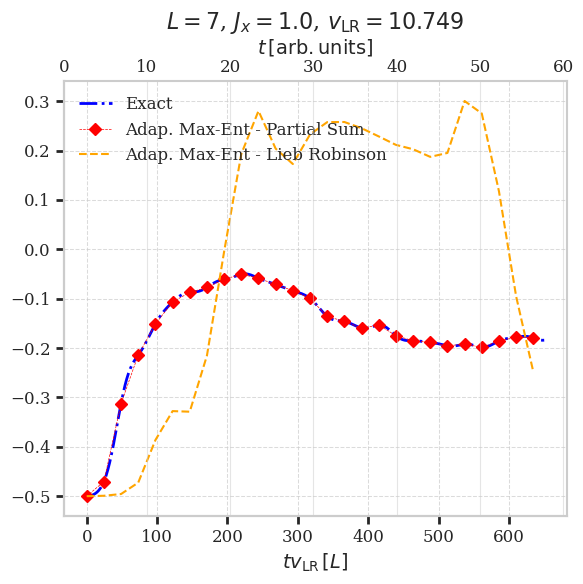

In [32]:
# Création de la figure et des axes
fig, ax = plt.subplots(figsize=(6, 6))

n=30
ax.plot(timespan * vLR, evs_obs_ex, label='Exact', color="blue", linestyle='dashdot', linewidth=2)
ax.plot(timespan[::n] * vLR, ev_obs_maxent_act_partialSum[::n], label='Adap. Max-Ent - Partial Sum', color='red', linestyle='--', marker='D', linewidth=0.5)
ax.plot(timespan[::n] * vLR, ev_obs_maxent_LR[:-1][::n], label='Adap. Max-Ent - Lieb Robinson', color='orange', linestyle='dashed')

# Bordures uniquement à gauche et en bas (style minimaliste)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Personnalisation des ticks
ax.tick_params(direction='out', length=6, width=2, which='major', grid_alpha=0.6)
ax.grid(True, which='major', linestyle='--', linewidth=0.75, alpha=0.7)

ax.legend(frameon=False, loc='upper left')

# Create a secondary x-axis (twinned) and set its limits
ax1 = ax.twiny()
ax1.set_xlim(timespan[0], timespan[-1])

# Set axis labels
ax.set_xlabel(r'$t v_{\rm LR} \, [L]$')
ax1.set_xlabel(r'$t \, [{\rm arb. units}]$')

# Format the title using the `params` dictionary values
# Ensure proper LaTeX formatting and consistent escape sequences
plt.title(r'$L={}$, $J_x={}$, $v_{{\rm LR}}={}$'.format(
    params['size'], 
    round(params['Jx'], 3), 
    round(vLR, 3)
))

# Ajustement final et affichage
plt.tight_layout()